In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.cort_processor import *

from src.plotter import *
from src.filters import *
import math
import pickle
import scipy
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import cm
from scipy import signal
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from matplotlib import colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import tdt 
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, hilbert, welch
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy.io import savemat
from src.phase_decoder_support import *
from src.neural_analysis import *
from src.wiener_filter import *
from src.folder_handler import *
from src.tdt_support import *
from src.decoders import *
import random

In [2]:
rollie1129 = CortProcessor('/mnt/c/oobootoo/rat-fes/data/meepo-injured-files/1004')
rollie1129.process(clear_storage = False)

read from t=0s to t=246.43s
read from t=0s to t=298.5s
read from t=0s to t=307.79s


(array([[20., 40., 40., ..., 40., 20., 60.],
        [60., 40., 60., ..., 20., 20., 20.],
        [20.,  0.,  0., ..., 40., 20., 40.],
        ...,
        [20., 20.,  0., ...,  0., 40., 60.],
        [ 0., 20.,  0., ..., 40., 20., 20.],
        [ 0.,  0.,  0., ...,  0., 20.,  0.]]),
 array([[ 96.83447267,  30.16114856,  32.36723442, ...,  67.29106944,
          75.28234185, 146.50262126],
        [112.59527659,  55.01824894,  49.48172506, ...,  75.61167036,
          74.86562375, 137.055587  ],
        [106.81237871,  49.07522976,  41.48453291, ...,  73.9578064 ,
          71.42929072, 132.80626531],
        ...,
        [ 42.53015631,  50.69772762, 112.09944035, ...,  99.71449285,
          79.48877642, 116.57887597],
        [ 42.36824141,  53.19870646, 116.89102993, ..., 104.34025744,
          79.42266324, 115.63043787],
        [ 42.93830777,  70.32944178, 131.76046615, ...,  99.55277141,
          79.81004473, 119.4518844 ]]))

In [3]:
rollie1129.kin_data[1]['fnum']

array([ 2000,  2001,  2002, ..., 56597, 56598, 56599])

In [4]:
rollie1129.kin_data[0]['bodyparts']

['toe',
 'MTP',
 'ankle',
 'knee',
 'pelvis bottom',
 'hip',
 'pelvis top',
 'finger',
 'knuckle',
 'wrist',
 'elbow',
 'shoulder',
 'scapula',
 'x1',
 'x2',
 'y1',
 'y2']

In [5]:
rollie1129.kin_data[0]['coords'].shape

(40800, 17, 3)

In [6]:
wrist_y = rollie1129.kin_data[0]['coords'][:, 9, 1]
scapula_y = rollie1129.kin_data[0]['coords'][:, 12, 1]
relative_y = wrist_y - scapula_y 
y_min = np.min(relative_y)
rel_y = relative_y - y_min
wrist_x = rollie1129.kin_data[0]['coords'][:, 9, 0]
knuckle_x = rollie1129.kin_data[0]['coords'][:, 8, 0]
finger_x = rollie1129.kin_data[0]['coords'][:, 7, 0]
shoulder_x = rollie1129.kin_data[0]['coords'][:, 11, 0]
relative_x = shoulder_x - wrist_x
min_x = np.min(relative_x)
rel_x = relative_x - min_x
relative_x2 = shoulder_x - knuckle_x
min_x2 = np.min(relative_x2)
rel_x2 = relative_x2 - min_x2
relative_x3 = shoulder_x - finger_x
min_x3 = np.min(relative_x3)
rel_x3 = relative_x3 - min_x3
fore_angle = rollie1129.kin_data[0]['angles'][:, 6]
fnum = rollie1129.kin_data[0]['fnum']

In [7]:
dy = np.diff(rel_y)
dx = np.diff(rel_x)
dt = 1/200
dydt_tmp = dy/dt
dxdt_tmp = dx/dt
ddy = np.diff(rel_y, 2)
ddx = np.diff(rel_x, 2)
ddyddt_tmp = ddy/(dt**2)
ddxddt_tmp = ddx/(dt**2)
dddy = np.diff(rel_y, 3)
dddydddt_tmp = dddy/(dt**3)
dddx = np.diff(rel_x, 3)
dddxdddt_tmp = dddx/(dt**3)

dtheta = np.diff(fore_angle)
dthetadt_tmp = dtheta/dt
ddtheta = np.diff(fore_angle, 2)
ddthetaddt_tmp = ddtheta/(dt**2)
dddtheta = np.diff(fore_angle, 3)
dddthetadddt_tmp = dddtheta/(dt**3)

dddxdddt = lowpass_filt(dddxdddt_tmp, 10, 200)
ddxddt = lowpass_filt(ddxddt_tmp, 10, 200)
dxdt = lowpass_filt(dxdt_tmp, 10, 200)

dddydddt = lowpass_filt(dddydddt_tmp, 10, 200)
ddyddt = lowpass_filt(ddyddt_tmp, 10, 200)
dydt = lowpass_filt(dydt_tmp, 10, 200)

dddthetadddt = lowpass_filt(dddthetadddt_tmp, 10, 200)
ddthetaddt = lowpass_filt(ddthetaddt_tmp, 10, 200)
dthetadt = lowpass_filt(dthetadt_tmp, 10, 200)

dddthetadddt = np.append(dddthetadddt, [0,0,0])
ddthetaddt = np.append(ddthetaddt, [0,0])
dthetadt = np.append(dthetadt, [0])

dddxdddt = np.append(dddxdddt, [0,0,0])
ddxddt = np.append(ddxddt, [0,0])
dxdt = np.append(dxdt, [0])

dddydddt = np.append(dddydddt, [0,0,0])
ddyddt = np.append(ddyddt, [0,0])
dydt = np.append(dydt, [0])

In [133]:
#############EVERYTHING HERE HAS ACCESS TO SEL

# def relative_x(self, 'mark_name'):
def relative_x_tmp(bodypart):
    if bodypart == 'shoulder':
        print('invalid selection')
        return None
    bp_num = rollie1129.data['bodyparts'].index(bodypart)
    sh_num = rollie1129.data['bodyparts'].index('shoulder')
    bodypart_x = rollie1129.kin_data[0]['coords'][:, bp_num, 0]
    shoulder_x = rollie1129.kin_data[0]['coords'][:, sh_num, 0]
    relative_x = shoulder_x - bodypart_x
    min_x = np.min(relative_x)
    rel_x = relative_x - min_x
    return rel_x


########EVERYTHING BELOW THIS POINT IS IN A SEPARATE IPYNB

def replace_with_null(arr, buffer):
    i = 0
    while i < len(arr):
        if arr[i] == 0:
            j = i
            while j < len(arr) and arr[j] == 0:
                j += 1
            if j - i >= buffer:
                for k in range(i, j):
                    arr[k] = None
            i = j
        else:
            i += 1
    return arr

def replace_null(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]) == True:
            arr[i] = 0
    return arr

def x_swing_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dddk = np.diff(kin_signal, 3)
    dddkdddt_tmp = dddk/(dt**3)
    dddkdddt = lowpass_filt(dddkdddt_tmp, 10, 200)
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    dddkdddt = np.append(dddkdddt, [0,0,0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_peaks, _ = spicy.signal.find_peaks(kin_signal, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.sort(kin_signal)[-probable_kink])
    dddkdddt_valleys, _ = spicy.signal.find_peaks(-(dddkdddt), distance= 50, threshold =10,prominence = 5, height = -0.5*np.sort(dddkdddt)[probable_kink])    
    print('dddkdddt_valleys:', len(dddkdddt_valleys))
    bdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[-probable_kink]
    print("swing threshold:", threshold*0.1)

    for i in range(len(dkdt)):
        if (dkdt[i]) >= threshold*0.1:
            bdkdt[i] = 1
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 1:
            if (bdkdt[i+1] == 0) and (bdkdt[i-1] == 0):
                bdkdt[i] = 0
    for i in range(1,len(bdkdt)-1,1):
        if (bdkdt[i]) == 0:
            if (bdkdt[i+1] == 1) and (bdkdt[i-1] == 1):
                bdkdt[i] = 1
    for i in range(0,len(bdkdt)-50,1):
        if (bdkdt[i] == 1) and (bdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while bdkdt[i+1+tick] == 1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in kin_peaks for val in index_list) or any(val in dddkdddt_valleys for val in index_list):
                if any(val in kin_peaks for val in index_list) and any(val in dddkdddt_valleys for val in index_list):
                    continue
                else:
                    for index in index_list:
                        bdkdt[index] = 0.5
            else:
                for index in index_list:
                    bdkdt[index] = 0  
    return bdkdt

    
def x_stance_binary(kin_signal):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    qdkdt = np.zeros((dkdt.shape[0]))
    threshold = np.sort(dkdt)[probable_kink]
    print("stance threshold:", threshold*0.1)
    for i in range(len(dkdt)):
        if (dkdt[i]) <= threshold*0.1:
            qdkdt[i] = -1
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == -1:
            if (qdkdt[i+1] == 0) and (qdkdt[i-1] == 0):
                qdkdt[i] = 0
    for i in range(1,len(qdkdt)-1,1):
        if (qdkdt[i]) == 0:
            if (qdkdt[i+1] == -1) and (qdkdt[i-1] == -1):
                qdkdt[i] = -1
    for i in range(0,len(qdkdt)-50,1):
        if (qdkdt[i] == -1) and (qdkdt[i-1] == 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while qdkdt[i+1+tick] == -1:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) or any(val in ddkddt_peaks for val in index_list):
                if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                    continue
                else:
                    for index in index_list:
                        qdkdt[index] = -0.5
            else:
                for index in index_list:
                    qdkdt[index] = 0
    return qdkdt

def slow_stance_exceptor(kin_signal, sss):
    dt = 1/200
    dk = np.diff(kin_signal)
    dkdt_tmp = dk/dt
    dkdt = lowpass_filt(dkdt_tmp, 10, 200)
    dkdt = np.append(dkdt, [0])
    ddk = np.diff(kin_signal,2)
    ddkddt_tmp = ddk/(dt**2)
    ddkddt = lowpass_filt(ddkddt_tmp, 10, 200)
    ddkddt = np.append(ddkddt, [0, 0])
    probable_kink = np.int64(len(kin_signal)*0.025)
    kin_valleys, _ = spicy.signal.find_peaks(-(kin_signal), wlen= 600, prominence = 3, distance = 50, height = -2*np.sort(kin_signal)[probable_kink])    
    ddkddt_peaks, _ = spicy.signal.find_peaks(ddkddt, prominence=3, distance= 50, height = 0.3*np.sort(ddkddt)[-probable_kink])    
    ddkddt_valleys, _ = spicy.signal.find_peaks(-(ddkddt), prominence=3, distance= 50, height = -0.3*np.sort(ddkddt)[probable_kink]) 
    ddkddt_peaks = ddkddt_peaks - 25
    ddkddt_valleys = ddkddt_valleys + 25
    sss_null = replace_with_null(sss, 30)
    for i in range(1,len(sss)-1,1):
        if sss[i] == 0 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) and sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -0.5 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss[i-1] in (-0.5, -1) or sss[i+1+tick] in (-0.5, -1):
                for index in index_list:
                    sss[index] = -1
    for i in range(1,len(sss)-1,1):
        if sss[i] == -1 and sss[i] != sss[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sss[i+1+tick] == sss[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if any(val in ddkddt_valleys for val in index_list) and any(val in ddkddt_peaks for val in index_list):
                continue
            else:
                for index in index_list:
                    sss[index] = -0.5
    sss = replace_null(sss)
    return sss

def stance_swing_trinary(sss, kin_signal = None, slow_stance_exception = False): 
    if sss is None and kin_signal is not None:
        swing_ind = x_swing_binary(kin_signal)
        stance_ind = x_stance_binary(kin_signal)
        sss = np.sum((swing_ind, stance_ind), axis = 0) 
        if slow_stance_exception == True:
            sss = slow_stance_exceptor(kin_signal, sss)
    
    sss_null = replace_with_null(sss, 30)
    for i in range(10,len(sss_null)-50,1):
        if (sss_null[i] == 0) and (sss_null[i-1] != 0):
            index_list = []
            index_list.append(i)
            tick = 0
            while sss_null[i+1+tick] == 0:
                index_list.append(i+1+tick)
                tick = tick+1
            if sss_null[i-1] is not None and sss_null[i+1+tick] is not None:
                if sss_null[i-1] == sss_null[i+1+tick]:
                    for index in index_list:
                        sss_null[index] = sss_null[i-1]
                elif len(index_list) > 1:
                    if len(index_list) % 2 == 1:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid+1:]:
                            sss_null[index] = sss_null[i+tick+1]
                    elif len(index_list) % 2 == 0:
                        mid = len(index_list)//2
                        for index in index_list[:mid]:
                            sss_null[index] = sss_null[i-1]
                        for index in index_list[mid:]:
                            sss_null[index] = sss_null[i+tick+1]
    for i in range(1,len(sss_null)-1,1):
        if (sss_null[i] == 0):
            if sss_null[i-1] is not None and sss_null[i+1] is not None:
                if (sss_null[i-1] != 0) and (sss_null[i+1] != 0):
                    if random.random() <= 0.5:
                        sss_null[i] = sss_null[i-1]
                    else:
                        sss_null[i] = sss_null[i+1]
    np.array(sss_null)
    sstrinary = replace_null(sss_null)
    return sstrinary


def scrubber(phase, length):
    adjustments = 0
    for i in range(1,len(phase)-1,1):
        if phase[i] != 0 and phase[i] != phase[i-1] and abs(phase[i]) < 1:
            index_list = []
            index_list.append(i)
            tick = 0
            while phase[i+1+tick] == phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if len(index_list) < length:
                if abs(phase[i-1]-phase[i]) < abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i-1]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) > abs(phase[i+1+tick]-phase[i]):
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1              
                elif phase[i-1] == phase[i+1+tick]:
                    for index in index_list:
                        phase[index] = phase[i+1+tick]
                        adjustments = adjustments+1
                elif abs(phase[i-1]-phase[i]) == abs(phase[i+1+tick]-phase[i]):
                    if abs(phase[i-1]) > abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i-1]
                            adjustments = adjustments+1
                    if abs(phase[i-1]) < abs(phase[i+1+tick]):
                        for index in index_list:
                            phase[index] = phase[i+1+tick]
                            adjustments = adjustments+1
            
    print(adjustments)
    return phase


def forelimb_phaser(slow_stance_exception = False):
    rel_x1 = relative_x_tmp('wrist')
    rel_x2 = relative_x_tmp('knuckle')
    rel_x3 = relative_x_tmp('finger')
    wrist_phase = stance_swing_trinary(sss= None, kin_signal = rel_x1, slow_stance_exception = slow_stance_exception)
    knuckle_phase = stance_swing_trinary(sss= None, kin_signal = rel_x2, slow_stance_exception = slow_stance_exception)
    finger_phase = stance_swing_trinary(sss= None, kin_signal = rel_x3, slow_stance_exception = slow_stance_exception)
    sum_phase = np.sum((wrist_phase, knuckle_phase, finger_phase), axis=0)
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 1.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 or sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -1.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 or sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(1,len(sum_phase)-1,1):
        if sum_phase[i] >= 0.5 and sum_phase[i] < 3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] >= 1.5 and sum_phase[i+1+tick] >= 1.5:
                for index in index_list:
                    sum_phase[index] = 3
        if sum_phase[i] <= -0.5 and sum_phase[i] > -3 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] <= -1.5 and sum_phase[i+1+tick] <= -1.5:
                for index in index_list:
                    sum_phase[index] = -3
    for i in range(len(sum_phase)):
        if sum_phase[i] < 1.5 and sum_phase[i] > -1.5:
            sum_phase[i] = 0
    sum_phase = sum_phase /3
    sum_phase = stance_swing_trinary(sss = sum_phase)
    sum_phase = scrubber(sum_phase, 10)
    for i in range(1,len(sum_phase)-1,1):
        if abs(sum_phase[i]) < 1 and sum_phase[i] != 0 and sum_phase[i] != sum_phase[i-1]:
            index_list = []
            index_list.append(i)
            tick = 0
            while sum_phase[i+1+tick] == sum_phase[i]:
                index_list.append(i+1+tick)
                tick = tick+1
            if sum_phase[i-1] == 0 or sum_phase[i+tick+1] == 0:
                for index in index_list:
                    sum_phase[index] = 0
            elif sum_phase[i] > 0:
                if sum_phase[i-1] < 0 and sum_phase[i+tick+1] < 0:
                    for index in index_list:
                        sum_phase[index] = 1
            elif sum_phase[i] < 0:
                if sum_phase[i-1] > 0 and sum_phase[i+tick+1] > 0:
                    for index in index_list:
                        sum_phase[index] = -1
    sum_phase = scrubber(sum_phase, 500)
    return sum_phase

In [157]:
stance_test = x_stance_binary(rel_x)
swing_test = x_swing_binary(rel_x)
sss = np.sum((swing_test, stance_test), axis = 0) 
sss = slow_stance_exceptor(rel_x, sss)

stance threshold: -17.132160398287613
dddkdddt_valleys: 244
swing threshold: 33.49290782256024


In [159]:
-171.32160398287613*0.05

-8.566080199143807

In [160]:
wrist_phase = x_trinary_phase(rel_x)
# knuckle_phase = x_trinary_phase(rel_x2)
# finger_phase = x_trinary_phase(rel_x3)

dddkdddt_valleys: 244
swing threshold: 33.49290782256024
stance threshold: -17.132160398287613


In [161]:
# sum_phase_tmp = np.sum((wrist_phase, knuckle_phase, finger_phase), axis=0)

In [162]:
fore_phase_test = forelimb_phaser(slow_stance_exception = True)

dddkdddt_valleys: 244
swing threshold: 33.49290782256024
stance threshold: -17.132160398287613
dddkdddt_valleys: 242
swing threshold: 35.85047101111562
stance threshold: -17.821394265759434
dddkdddt_valleys: 241
swing threshold: 37.20005922580717
stance threshold: -18.60369299155951
13
0


In [163]:
# peaks_theta, _ = spicy.signal.find_peaks(fore_angle, wlen= 600, prominence = 3, distance = 100, height = 0.4*np.sort(fore_angle)[-1000])    
# neg_peaks_theta, _ = spicy.signal.find_peaks(-(fore_angle), wlen= 600, prominence = 3, distance = 100, height = -0.5*np.sort(fore_angle)[1000])    
# peaks_dthetadt_plus, _ = spicy.signal.find_peaks(dthetadt, prominence=3, distance= 100)    
# peaks_dthetadt_minus, _ = spicy.signal.find_peaks(-(dthetadt), prominence=3, distance= 100)    
# peaks_ddthetaddt_plus, _ = spicy.signal.find_peaks(ddthetaddt, prominence=3, distance= 100)    
# peaks_ddthetaddt_minus, _ = spicy.signal.find_peaks(-(ddthetaddt), prominence=3, distance= 100)    
# peaks_dddthetadddt_minus, _ = spicy.signal.find_peaks(-(dddthetadddt), distance= 50, prominence = 5, height = -0.02*np.sort(dddthetadddt)[1000])    


peaks_relx, _ = spicy.signal.find_peaks(rel_x, wlen= 600, prominence = 3, distance = 50, height = 0.4*np.sort(rel_x)[-1000])
neg_peaks_relx, _ = spicy.signal.find_peaks(-(rel_x), wlen= 600, prominence = 3, distance = 50, height = -1.75*(np.sort(rel_x)[1000]))
peaks_dxdt_plus, _ = spicy.signal.find_peaks(dxdt, prominence=3, distance= 50, height = 0.2*np.sort(dxdt)[-1000])    
peaks_dxdt_minus, _ = spicy.signal.find_peaks(-(dxdt), prominence=3, distance= 50, height = -0.2*np.sort(dxdt)[1000])    
peaks_ddxddt_plus, _ = spicy.signal.find_peaks(ddxddt, prominence=3, distance= 50, height = 0.3*np.sort(ddxddt)[-1000])    
peaks_ddxddt_minus, _ = spicy.signal.find_peaks(-(ddxddt), prominence=3, distance= 50, height = -0.3*np.sort(ddxddt)[1000])    
peaks_dddxdddt_minus, _ = spicy.signal.find_peaks(-(dddxdddt), distance= 50, threshold =10,prominence = 5, height = -0.5*np.sort(dddxdddt)[1000])    

In [164]:
print(len(peaks_dddxdddt_minus))

244


No handles with labels found to put in legend.


Text(0.5, 1.0, 'reconstructed phase')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
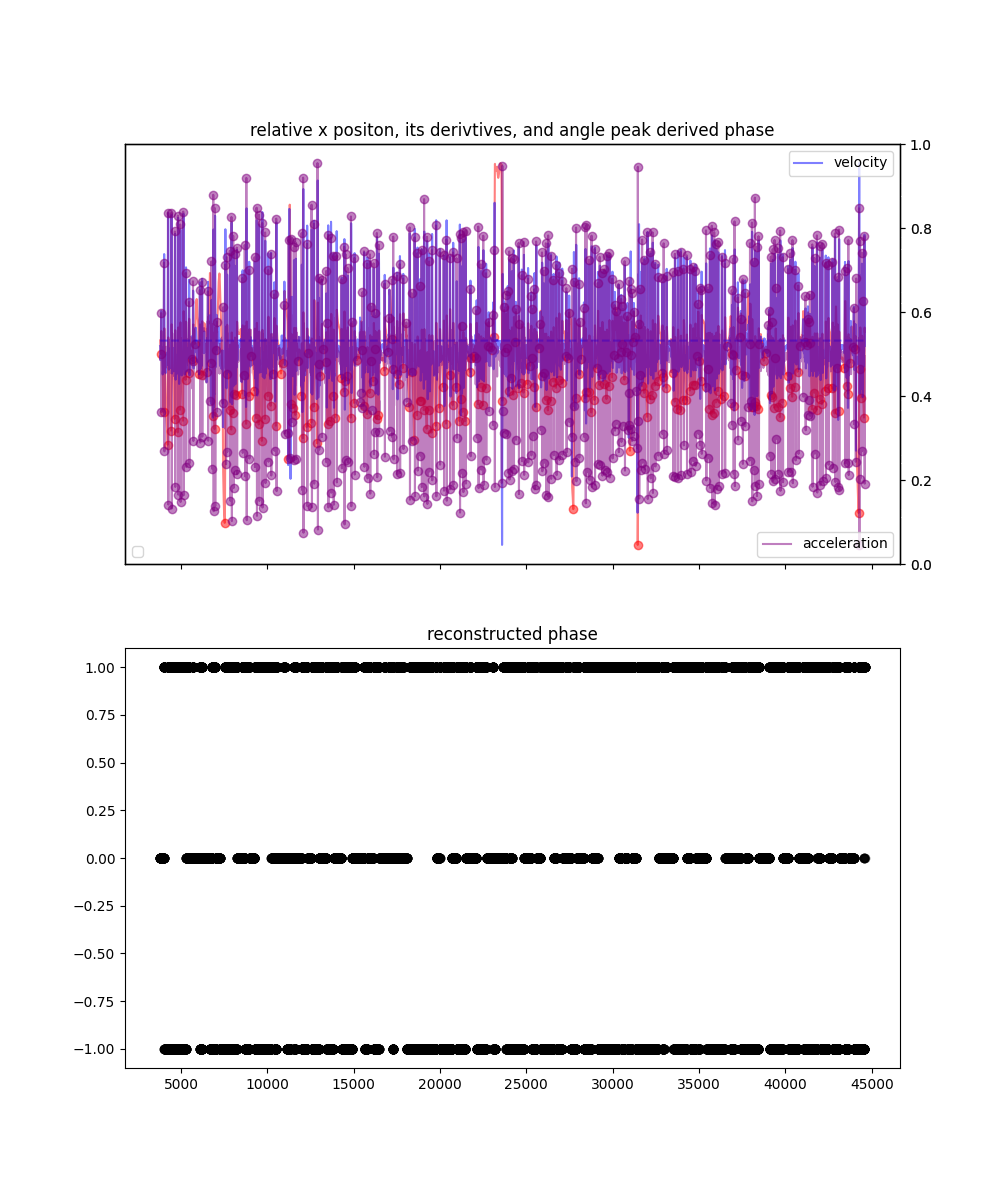

In [165]:
figq, (ax0, ax4) = plt.subplots(2, 1, figsize=(10,12),sharex = True)
weird_test = np.sort(dxdt)

ax00 = ax0.twinx()    
ax000 = ax0.twinx()    
ax0000 = ax0.twinx()    
ax00000 = ax0.twinx()  
ax000000 = ax0.twinx()
ax0.plot(fnum, rel_x, c = 'r', alpha = 0.5, label= 'position')
# ax0.scatter(fnum[peaks_relx], rel_x[peaks_relx], c = 'r', alpha = 0.5)
ax0.scatter(fnum[neg_peaks_relx], rel_x[neg_peaks_relx], c = 'r', alpha = 0.5)

ax0000.scatter(fnum[peaks_ddxddt_plus], ddxddt[peaks_ddxddt_plus], c = 'purple', alpha = 0.5)
ax0000.scatter(fnum[peaks_ddxddt_minus], ddxddt[peaks_ddxddt_minus], c = 'purple', alpha = 0.5)
ax0000.plot(fnum, ddxddt, c = 'purple', alpha = 0.5, label = 'acceleration')
# ax00000.plot(fnum, dddxdddt, c = 'green', alpha = 0.5, label = 'jerk')
# ax0.legend(loc='upper left')
ax00.plot(fnum, np.zeros(dxdt.shape[0])+20, c = 'b', alpha = 0.5, linestyle = '--')
# ax0000.plot(fnum, np.zeros(ddxddt.shape[0]), c = 'purple', alpha = 0.5, linestyle = '--')
# ax00000.plot(fnum, np.zeros(dddxdddt.shape[0]), c = 'green', linestyle = '--', alpha = 0.5)
# ax00000.scatter(fnum[peaks_dddxdddt_minus], dddxdddt[peaks_dddxdddt_minus], c = 'green', alpha = 0.5)

ax00.plot(fnum, dxdt, c = 'b', alpha = 0.5, label = 'velocity')
# ax00.scatter(fnum[peaks_dxdt_plus], dxdt[peaks_dxdt_plus], c = 'b', alpha = 0.5)
# ax00.scatter(fnum[peaks_dxdt_minus], dxdt[peaks_dxdt_minus], c = 'b', alpha = 0.5)

# ax000000.scatter(fnum, wrist_phase, c = 'k', alpha = 0.5)

ax00.legend(loc='upper right')
ax0000.legend(loc='lower right')
ax00000.legend(loc='lower left')
ax0.tick_params(axis='y', colors='white')
ax00.tick_params(axis='y', colors='white')
ax0000.tick_params(axis='y', colors='white')
ax00000.tick_params(axis='y', colors='white')
ax0.set_title("relative x positon, its derivtives, and angle peak derived phase")


ax4.scatter(fnum, fore_phase_test, c = 'k', alpha = 0.5)
# # ax4.scatter(fnum, swing_test+stance_test, c = 'purple', alpha = 0.25)
# ax4.scatter(fnum, sss, c = 'yellow', alpha = 0.25)

# ax4.scatter(fnum, stance_test, c = 'b', alpha = 0.5)

ax4.tick_params(axis='y', colors='black')
ax4.set_title("reconstructed phase")

# ax2.axvline(x = 36230 , c = 'k', alpha = 0.5, linestyle = '--')
